# Session 2: Win Big at Monte Carlo

## Colab Setup

In [1]:
#uncomment only if you're running from google colab
!git clone https://github.com/Datatouille/rl-workshop
!mv rl-workshop/* .
!ls
!pip install gym #For full installations, see https://github.com/openai/gym#installation

Cloning into 'rl-workshop'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 116 (delta 54), reused 95 (delta 36), pack-reused 0
Receiving objects: 100% (116/116), 1.66 MiB | 25.72 MiB/s, done.
Resolving deltas: 100% (54/54), done.
img	 models     rl-workshop  session0.ipynb  session2b.ipynb  solutions
LICENSE  README.md  sample_data  session1.ipynb  session2.ipynb
    100% |████████████████████████████████| 1.5MB 15.1MB/s 
    100% |████████████████████████████████| 1.0MB 21.5MB/s 
  Running setup.py bdist_wheel for gym ... - \ | / done
  Stored in directory: /root/.cache/pip/wheels/ea/ec/dd/33bcc8801d345f0b640fced8a0864a7c8474828564bc5ccf70
Successfully built gym


## Imports

In [1]:
%matplotlib inline

import gym
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle
from tqdm import trange
import seaborn as sns
import pandas as pd
from random import random
import warnings
warnings.filterwarnings("ignore")

#cross check with our solutions once you finish
from solutions.agents import BJAgent

MODEL_PATH = 'models/'


'''
Helper function from Udacity Deep Reinforcement Learning Nanodegree
#https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py
Many great examples with MIT License.
'''
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

ModuleNotFoundError: No module named 'gym'

## Recap

### What is Reinforcement Learning

In [0]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/SvXXpmXedHE" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>

Reinforcement learning formulates interaction between an **agent** and its **environment** as **Markov decision processes**. For a given **state**, an agent takes an **action** based on the current **state**. In response to that action at that state, the agent will then get some **reward** from the environment, and that state changes to the next one.

$S_0 \rightarrow A_0 \rightarrow R_1 \rightarrow S_1 \rightarrow A_1 \rightarrow R_2 \rightarrow S_2 \rightarrow ... \rightarrow S_{t-1} \rightarrow A_{t-1} \rightarrow R_t \rightarrow S_{t}$

![RL Framework](https://github.com/alderaan/ml_workshop/blob/master/img/rl_framework.png?raw=1)
Source: [Sutton and Barto](https://cdn.preterhuman.net/texts/science_and_technology/artificial_intelligence/Reinforcement%20Learning%20%20An%20Introduction%20-%20Richard%20S.%20Sutton%20,%20Andrew%20G.%20Barto.pdf)

### How An Agent Choose to Act Aka Select A Policy

**Prediction Problem**

State Value
$$v_\pi(s) = \sum_{a \in \mathcal{A}(s)}\pi(a|s)\sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma v_\pi(s'))$$
(State-)Action Value
$$q_\pi(s,a) = \sum_{s' \in \mathcal{S}, r\in\mathcal{R}}p(s',r|s,a)(r + \gamma\sum_{a' \in \mathcal{A}(s')} \pi(a'|s') q_\pi(s',a'))$$

**Control Problem**

Choose the action with the highest action value.

$$\pi^*(s) = argmax_{a \in \mathcal{A}}q^*(s,a)$$

But how do we deal with stochastic environment and policy?

## Enter Monte Carlo

There are two main approaches in solving reinforcement learning: **model-based** and **model-free** approaches. 

The model-based approach assumes that we have some or full knowledge of how our environment works (God-mode GridWorld).

**The model-free approach relies on our agent to explore the environment without any prior knowledge.**

We start with the Monte Carlo Methods aka the trial-and-error-until-you-get-rich-or-broke methods.

<img src="https://github.com/alderaan/ml_workshop/blob/master/img/monte_carlo.jpg?raw=1" alt="Monte Carlo Casino" width=75%/>

## [Blackjack-v0](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)

We are going to play the variant of blackjack problem described in Example 5.1 in [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/the-book-2nd.html). The rules are almost the same as a typical casino poker except for:
* There are only two actions for the player: hit or stay
* Cards are dealt randomly with replacement from a standard 52-card deck

<img src="https://github.com/alderaan/ml_workshop/blob/master/img/blackjack_scores.PNG?raw=1" alt="Blackjack Scores" />

## Notes David
* one should always hit if current sum <= 11.<br>
* useable ace: an ace that can be used as 11 without going bust. that means current sum is 10 or less. it is always counted as 11, as otherwise there would be no decision to be made, as one should always hit when current sum <= 11 .
* to get state-value function, play many games and average the returns for each state.
* The player should take into account 3 variables: 
  * his current sum (12-21)
  * dealers one showing card (ace-10)
  * holding usable ace yes/no

In [0]:
env = gym.make('Blackjack-v0')

**Concept Assignment** Using the reinforcement learning scheme we learned from last class, what would Blackjack-v0 look like?

* Environment: Blackjack table
* Agent: Player
* States:
* Actions:
* Rewards: 
* Episodes:

### Observation Space (State Space)

The state is a tuple with three elements:
* The player's current score (0-31)
* The dealer's showing card (1-10)
* 1 if the player has a usable ace; 0 if the player does not.

In [0]:
env.observation_space

Tuple(Discrete(32), Discrete(11), Discrete(2))

In [0]:
env.reset()

(13, 8, False)

### Action Space

* 0 - stick
* 1 - hit

In [0]:
env.action_space

Discrete(2)

### Reward

* +1 for winning
* -1 for losing
* +1.5 for winning with a natural Blackjack (21 starting hand)

In [8]:
print(f'State: {env.reset()}')
print(f'Result: {env.step(0)} Dealer has {sum(env.dealer)}') #next state, reward, done, info

State: (15, 5, False)
Result: ((15, 5, False), 1.0, True, {}) Dealer has 25


### Human Play

Play a couple of rounds with your own natural neural networks to get a hang of the environment.

In [7]:
state = env.reset()
print(f'Starting hands: You have {state[0]}. Dealer is showing {state[1]}')
done = False
while not done:
    action = int(input('Choose action: '))
    state, reward, done, info = env.step(action)
    print(f'After taking action {action}, You have {state[0]}. Usable ace: {state[2]}')
    if done:
        print(f'You have {state[0]}, Dealer has {sum(env.dealer)}, Reward: {reward}')

Starting hands: You have 20. Dealer is showing 2
Choose action: 0
After taking action 0, You have 20. Usable ace: False
You have 20, Dealer has 22, Reward: 1.0


### Computer Play

**Coding Assignment** Write the function `run_single_episode` to simulate an agent playing at random (50% stick / 50% hit) for one episode.

In [0]:
def run_single_episode():
    result = []
    state = env.reset()
    while True:
        #write your code here
        break
    return(result) #must return a list of tuples (state,action,reward,next_state,done)

## Optimal Strategy for Blackjack

Black Jack is the game with one of the best odds in the casino. [Ed Thorp (1966)](http://www.eecs.harvard.edu/cs286r/courses/fall12/papers/Thorpe_KellyCriterion2007.pdf) has derived the basic optimal strategy of playing the game using the [Kelly Criterion](http://www.herrold.com/brokerage/kelly.pdf) as the following figure. Those interested in the derivation should check out Thorp's book [Beat the Dealer](https://www.amazon.com/Beat-Dealer-Winning-Strategy-Twenty-One/dp/0394703103) as well as [Bringing Down The House](https://www.amazon.com/gp/product/0743249992/) by Ben Mezrich and its movie adaptation [21](https://www.imdb.com/title/tt0478087/). But for today, we will have nothing to do with the math and everything to do with reinforcement learning, Monte Carlo method.

<img src="https://github.com/alderaan/ml_workshop/blob/master/img/ed_thorp.PNG?raw=1" alt="Basic Optimal Strategy for Black Jack" />

In [9]:
#run single episode
def run_single_episode(policy=None):
    result = []
    state = env.reset()
    while True:
        action = policy[state] if policy else env.action_space.sample()
        next_state,reward,done,info = env.step(action)
        result.append((state,action,reward,next_state,done))
        state = next_state
        if done: break
    return(result) #must return a list of tuples (state,action,reward,next_state,done)

#load saved optimal q dictionary
optimal_q = pickle.load(open(f'{MODEL_PATH}bj_optimal_q.pkl','rb'))
#convert to optimal policy
optimal_policy = {state:np.argmax(value) for state, value in optimal_q.items()}
#stick only as control 
stick_policy = {state: 0 for state,value in optimal_policy.items()}

n_trial = 100000
sticks = []
randoms = []
optimals = []
for i in trange(n_trial):
    _,_,rewards_stick,_,_ = zip(*run_single_episode(stick_policy))
    _,_,rewards_random,_,_ = zip(*run_single_episode())
    _,_,rewards_optimal,_,_ = zip(*run_single_episode(optimal_policy))
    sticks.append(rewards_stick[-1])
    randoms.append(rewards_random[-1])
    optimals.append(rewards_optimal[-1])

100%|██████████| 100000/100000 [00:10<00:00, 9712.36it/s]


In [12]:
result = pd.DataFrame({'stick':sticks,'random':randoms,'optimal':optimals})
print(result.describe().iloc[:3,:])
sns.barplot(data=result_m, x ='variable', y ='value')

             optimal         random         stick
count  100000.000000  100000.000000  100000.00000
mean       -0.051330      -0.395060      -0.18634
std         0.952746       0.894894       0.95611


NameError: ignored

## Fill in The Code

In [0]:
# import numpy as np
# from collections import defaultdict
# import sys
# import random
# from tqdm import trange

# # """
# # Coding assignment order:
# # 1. mc_control_q
# # *2. mc_control_glie
# # *Do in-class if possible
# # """
# class BJAgent:
#     def __init__(self, env, gamma = 1.0, 
#                  start_epsilon = 1.0, end_epsilon = 0.05, epsilon_decay = 0.99999):
        
#         self.env = env
#         self.n_action = self.env.action_space.n
#         self.policy = defaultdict(lambda: 0) #always stay as best policy
#         self.v = defaultdict(lambda:0) #state value initiated as 0
#         self.gamma = gamma
        
#         #action values
#         self.q = defaultdict(lambda: np.zeros(self.n_action)) #action value
#         self.g = defaultdict(lambda: np.zeros(self.n_action)) #sum of expected rewards
#         self.n_q = defaultdict(lambda: np.zeros(self.n_action)) #number of actions performed
        
#         #epsilon greedy parameters
#         self.start_epsilon = start_epsilon
#         self.end_epsilon = end_epsilon
#         self.epsilon_decay = epsilon_decay
    
#     #get epsilon
#     def get_epsilon(self,n_episode):
#         epsilon = max(self.start_epsilon * (self.epsilon_decay ** n_episode), self.end_epsilon)
#         return(epsilon)
    
#     #select action based on epsilon greedy
#     def select_action(self,state,epsilon):
#         best_action = np.argmax(self.policy[state]) if state in self.q else self.env.action_space.sample()
#         if random.random() > epsilon:
#             action = best_action
#         else:
#              action = self.env.action_space.sample()
#         return(action)
    
#     #run episode with current policy
#     def run_episode(self, epsilon):
#         result = []
#         state = self.env.reset()
#         while True:
#             action = self.select_action(state,epsilon)
#             next_state,reward,done,info = self.env.step(action)
#             result.append((state,action,reward,next_state,done))
#             state = next_state
#             if done: break
#         return(result)
    
#     #update policy to reflect q values
#     def update_policy_q(self):
#         for state, value in self.q.items():
#             self.policy[state] = np.argmax(value)
        
#     #mc control
#     def mc_control_q(self,n_episode=500000,first_visit=True,update_every=1):
#         for t in trange(n_episode):
#             traversed = []
#             e = self.get_epsilon(t)
#             transitions = self.run_episode(e)
#             states,actions,rewards,next_states,dones = zip(*transitions)
#             #mc prediction
#             for i in range(len(transitions)):
#                 discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
#                 if first_visit and ((states[i],actions[i]) not in traversed):
#                     traversed.append((states[i],actions[i]))
                    
#                     '''
#                     Write your code here to implement first-visit monte carlo 
#                     '''
                    
#                 else:
                    
#                     '''
#                     Write your code here to implement all-visit monte carlo 
#                     '''
                    
#             #update policy every few episodes seem to be more stable
#             if t % int(update_every * n_episode - 1) ==0:
#                 self.update_policy_q()
#         #final policy update at the end
#         self.update_policy_q()
    
#     #mc control glie
#     def mc_control_glie(self,n_episode=500000,lr=0.,update_every=1):
#         for t in trange(n_episode):
#             traversed = []
#             e = self.get_epsilon(t)
#             transitions = self.run_episode(e)
#             states,actions,rewards,next_states,dones = zip(*transitions)
            
#             #mc prediction
#             for i in range(len(transitions)):
#                 discounts = np.array([self.gamma**j for j in range(len(transitions)+1)])
#                 traversed.append((states[i],actions[i]))
                
#                 '''
#                 Write your code here to implement glie monte carlo 
#                 '''
       
#             #update policy every few episodes seem to be more stable
#             if t % int(update_every * n_episode - 1)==0:
#                 self.update_policy_q()
#         #final policy update at the end
#         self.update_policy_q()
        
#     #get state value from action value
#     def q_to_v(self):
#         for state, value in self.q.items():
#             self.v[state] = np.max(value)

## What is Monte Carlo Method

You can think of it as a fancy way of saying **trial-and-error for some iterations then find an average**.

An engineer would say pi is 3.144.


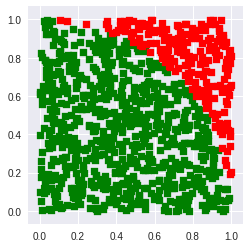

In [13]:
'''
Code stolen from https://stackoverflow.com/questions/43703757/plotting-pi-using-monte-carlo-method#43703895
'''
inside = 0
n = 10**3

x_inside = []
y_inside = []
x_outside = []
y_outside = []

for _ in range(n):
    x = random()
    y = random()
    if x**2+y**2 <= 1:
        inside += 1
        x_inside.append(x)
        y_inside.append(y)
    else:
        x_outside.append(x)
        y_outside.append(y)

pi = 4*inside/n
print(f'An engineer would say pi is {pi}.')

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(x_inside, y_inside, color='g', marker='s')
ax.scatter(x_outside, y_outside, color='r', marker='s')
fig.show()

## Prediction Problem: (State-)Action Value Prediction

**Concept Assignment** Why do we need Monte Carlo method for action value predictions?

*Hint* Think about stochastic or deterministic environment and agent.

**Concept Assignment** Is first-visit and all-visit Monte Carlo the same or different for Black Jack and why?

![Monte Carlo Action Value Prediction](https://github.com/alderaan/ml_workshop/blob/master/img/mc_predict_q.png?raw=1)

## Control Problem: All-Visit and First-Visit Monte Carlo

Monte carlo control is just doing:
$$\pi^*(s) = argmax_{a \in \mathcal{A}}q^*(s,a)$$
after a few or all episodes of trial.

**Coding Assigment** Implement all-visit and first-visit Monte Carlo control in the function `mc_control_q`

In [14]:
a = BJAgent(env)
a.mc_control_q()

100%|██████████| 500000/500000 [00:45<00:00, 11080.82it/s]


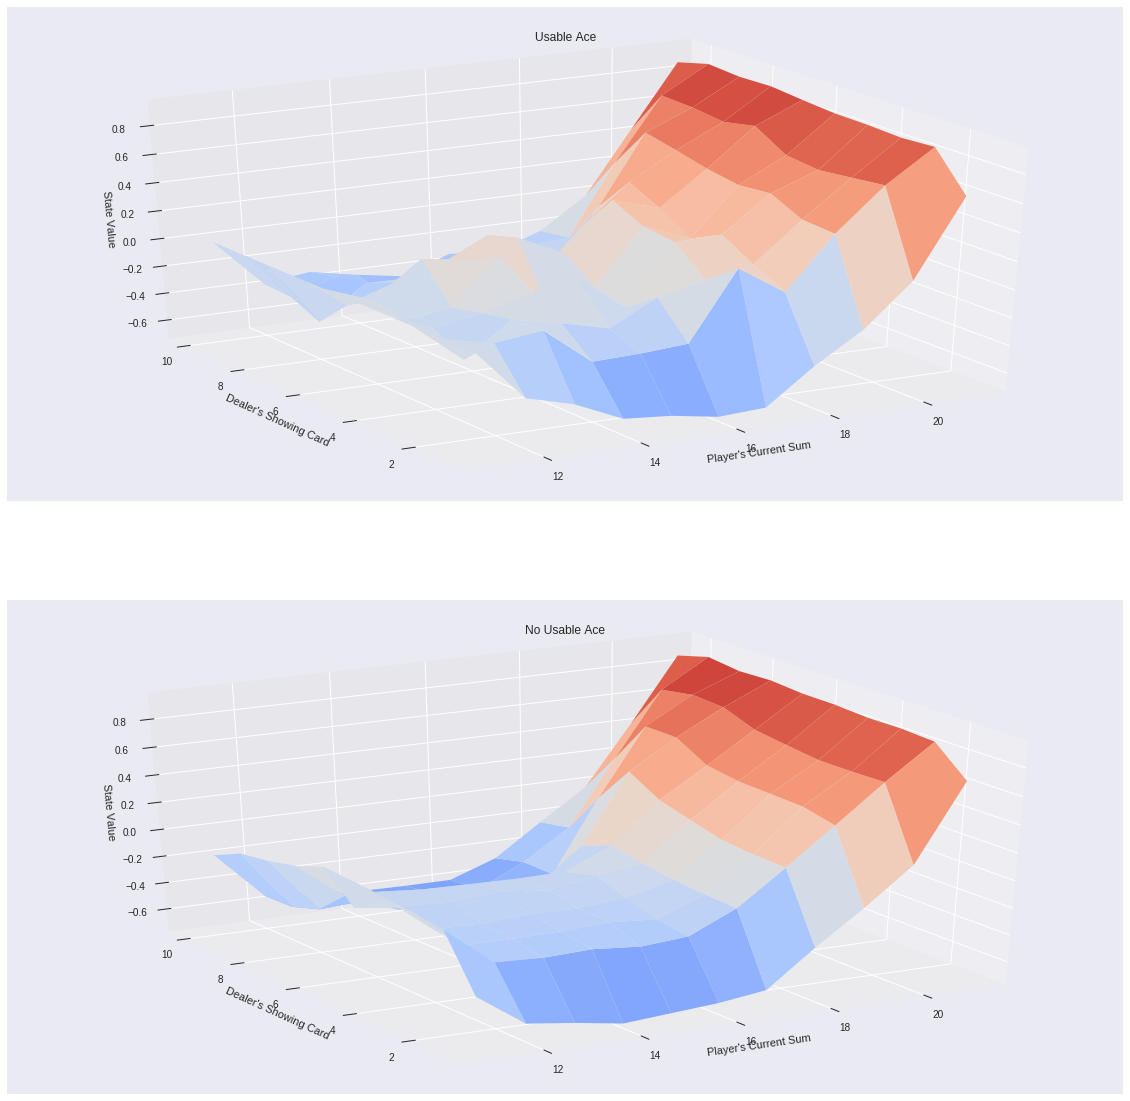

In [15]:
a.q_to_v()
plot_blackjack_values(a.v)

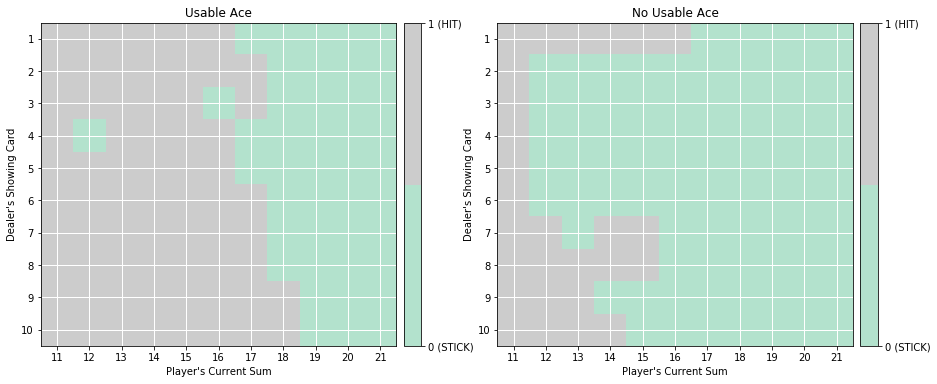

In [0]:
plot_policy(a.policy)

## Control Problem: Greedy within The Limit of Exploration (GLIE)

**Concept Assignment** When do we update action values q in first-visit and all-visit Monte Carlo? Do you think we can do better?

A throwback to elementary school years: how to update an average with a new value?

$$
\begin{aligned}
\bar{x}_{new} = \frac{(n-1)\bar{x}_{old} + {x}_{i}}{n}
= \frac{n\bar{x}_{old} - \bar{x}_{old} + {x}_{i}}{n}
= \bar{x}_{old} + \frac{1}{n}(x_{i} - \bar{x}_{old})
\end{aligned}
$$


where:
* $\bar{x}_{new}$ is the new average, here equivalent to the new $Q(S_t,A_t)$
* $\bar{x}_{new}$ is the new average, here equivalent to the old $Q(S_t,A_t)$
* ${x}_{i}$ is the newly added item, here equivalent to $G_t$
* $n$ is the new total number of items, here equivalent to $N(S_t,A_t)$

![Greedy within The Limit of Exploration](https://github.com/alderaan/ml_workshop/blob/master/img/mc_control_glie.png?raw=1)

**Coding Assigment** Implement GLIE Monte Carlo control in the function `mc_control_glie`

In [0]:
a = BJAgent(env)
a.mc_control_glie()

100%|██████████| 500000/500000 [00:36<00:00, 13619.75it/s]


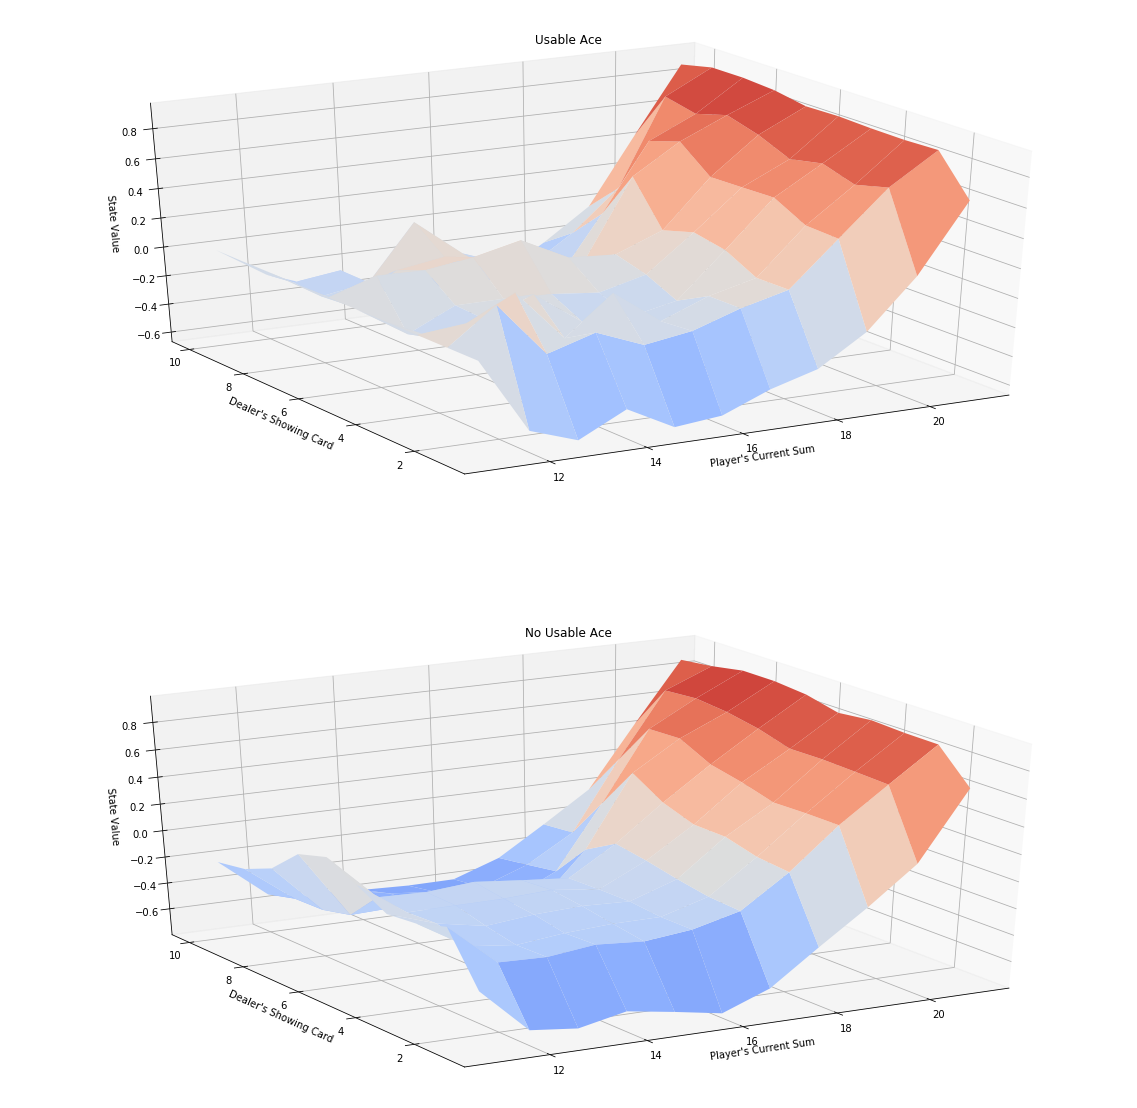

In [0]:
a.q_to_v()
plot_blackjack_values(a.v)

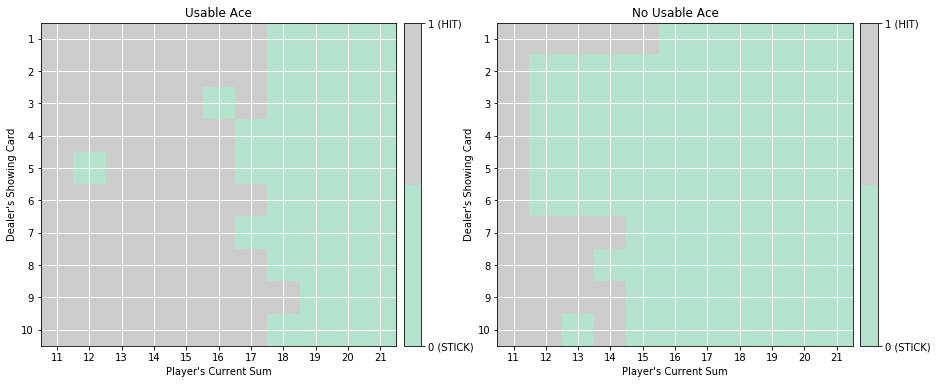

In [0]:
plot_policy(a.policy)

In [0]:
#export q
# pickle.dump(dict(a.q), open(f'{MODEL_PATH}bj_optimal_q.pkl','wb'))

## Challenges

* What are some other ways of solving reinforcement learning problems? How are they better or worse than Monte Carlo methods e.g. performance, data requirements, etc.?
* Solve at least one of the following OpenAI gym environments with discrete states and actions:
    * FrozenLake-v0
    * Taxi-v2
    * Blackjack-v0
    * Any other environments with discrete states and actions at [OpenAI Gym](https://github.com/openai/gym/wiki/Table-of-environments)
* Check `session2b.ipynb` if you are interested in using Monte Carlo method to solve Grid World. This will give you more insight into difference between all-visit and first-visit Monte Carlo.

## References

* Kelly, J. L. (1956). "A New Interpretation of Information Rate" (PDF). Bell System Technical Journal. 35 (4): 917–926. doi:10.1002/j.1538-7305.1956.tb03809.x.
* Thorp, E.O. (1966). Beat the Dealer, second ed. Vintage, New York